In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import simtk.openmm as mm

# Umbrella Sampling

## Sistema de tests: Doble pozo

In [3]:
from uibcdf_test_systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT
from uibcdf_test_systems.analysis import get_probability_density

In [4]:
# Parametros del sistema y el potencial

parametros_potencial ={
    'Eo' : 4.0 * unit.kilocalories_per_mole,
    'a' : 1.0 * unit.nanometers,
    'b' : 0.25 * unit.kilocalories_per_mole
}

parametros_sistema = {
    'n_particles' : 1,
    'mass' : 14.007 * unit.amu
}

# Sistema
double_well_asymmetric = DoubleWell(**parametros_sistema, **parametros_potencial)

In [5]:
# Parametros del estado termodinámico
T = 300*unit.kelvin

# Condiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers

# Simulación
times, positions, _, _, _ = langevin_NVT (double_well_asymmetric.system, temperature = T,
                                          friction = 1.0/unit.picoseconds,
                                          initial_positions = initial_positions,
                                          integration_timestep = 0.2 * unit.picoseconds,
                                          saving_timestep = 10.0 * unit.picoseconds,
                                          total_time = 0.1 * unit.microseconds)

100%|██████████| 9999/9999 [00:23<00:00, 427.07it/s]


In [6]:
prob_density, coors_x, bins, delta_x = get_probability_density (positions[:,0,0], [-2.0,2.0]*unit.nanometers, 400)
prob_density_teo, _, _, _ = get_probability_density (double_well_asymmetric, [-2.0,2.0]*unit.nanometers, 400, T)

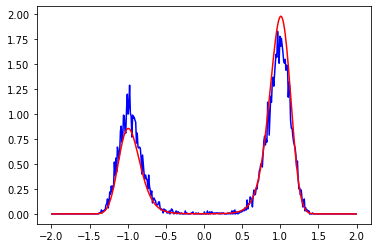

In [7]:
plt.plot(coors_x, prob_density, color='blue')
plt.plot(coors_x, prob_density_teo, color='red')
plt.show()

## Teoria

En el caso canónico unidimensional:

\begin{equation}
P(x) \propto e^{-\frac{U(x)}{k_{B}T}}
\end{equation}

Si por ejemplo estamos definiendo una coordenada de reacción lineal $L(q)$ en un espacio multidimensional la expresión tiene sentido cuando integramos todos los grados de libertad que se proyectan sobre un mismo valor $l$:

\begin{equation}
P(l) \propto \int_{-\infty}^{\infty} e^{-\frac{U(\vec{q})}{k_{B}T}} \delta (l - L(\vec{q})) d\vec{q}
\end{equation}

En todo caso, la energía libre de un estado (o microestado), de una proyección sobre una coordenada de reacción, un subespacio del espacio conformacional (una discretización
 por ejemplo), tiene la forma:

\begin{equation}
F(l) = -k_{B}T \ln (P(l))
\end{equation}

En el caso de un sistema unidimensional, si no discretizamos el espacio, no hacemos regiones, la energía libre coincide con el potencial.

Para confinar el sistema en una región podemos añadir un potencial adicional $V(x)$. Esta práctica es muy conveniente en el caso por ejemplo de que no queramos que el sistema, o parte del sistema, explore regiones no deseadas. Por ejemplo en el caso de confinar un ligando en el sitio de unión, o junto a la superficie de la proteína para el caso del estudio de un sistema receptor-ligando.

En este caso haremos que el potencial auxiliar $V(x)$ sea un pozo armónico:

\begin{equation}
V(x)=\frac{1}{2} k (x-x_{0})^{2},
\end{equation}

donde $k$ es la constante de rigidez del potencial armónico usado para restringir la exploración, y $x_{0}$ la ubicación del mínimo. Veamos como podemos introducir en nuestro sistema de doble pozo unidimensional este potencial adicional:

In [8]:
k = 30.0 * unit.kilocalories_per_mole/unit.nanometer**2
xo = 0.4 * unit.nanometers

force = mm.CustomExternalForce('0.5*k*(x-xo)^2')
force.addGlobalParameter('k', k)
force.addGlobalParameter('xo', xo)
for ii in range(double_well_asymmetric.n_particles):
    force.addParticle(ii, [])
double_well_asymmetric.system.addForce(force) 

1

El objeto 'double_well_asymmetric.system' ha sido modificado para incluir nuestro potencial armónico extra. Ya no es el sistema doble pozo:

In [9]:
def double_well_plus_harmonic(x,Eo,a,b,k,xo):
    return Eo*((x/a)**4-2*(x/a)**2)-(b/a)*x + 0.5*k*(x-xo)**2

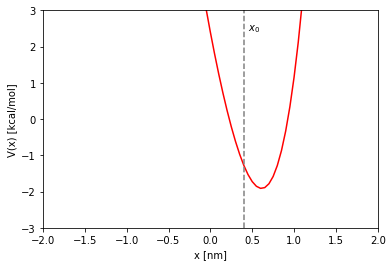

In [10]:
x_serie = np.arange(-5., 5., 0.05) * unit.nanometers
Vx_serie = double_well_plus_harmonic(x_serie, **parametros_potencial, k=k, xo=xo)

plt.plot(x_serie, Vx_serie, 'r-')
plt.axvline(x=xo._value,linestyle='--',color='gray')
plt.ylim(-3,3)
plt.xlim(-2,2)
plt.xlabel("x [{}]".format(x_serie.unit.get_symbol()))
plt.ylabel("V(x) [{}]".format(Vx_serie.unit.get_symbol()))
plt.text(xo._value+0.05, 2.5,'$x_{0}$', horizontalalignment='left', verticalalignment='center')
plt.rcParams['figure.figsize'] = 6,4
plt.show()

Veamos el comportamiento del nuevo sistema de doble pozo asimétrico más el potencial harmónico. En primer lugar debemos observar que al introducir un potencial extra, especialmente si es un potencial que tiene por objeto confinar al sistema, debemos preguntarnos si no hemos introducido una posible fuente de problemas con el paso del integrador. El periodo de oscilación de una partícula de masa $m$ en un potencial armónico tiene la forma:

\begin{equation}
T=2\pi \sqrt{\frac{m}{k}}
\end{equation}

Para hacer la consulta de manera más sencilla, podemos recurrir al objeto 'HarmonicWell' encontrado en la librería uibcdf_test_systems:

In [11]:
from uibcdf_test_systems import HarmonicWell
pozo_armonico = HarmonicWell(n_particles=1, mass=parametros_sistema['mass'], k=k)

In [12]:
pozo_armonico.oscillation_period

Quantity(value=2.0989203941784234, unit=picosecond)

Otra magnitud relevante a la hora de ganar intuición sobre cual puede ser el efecto del potencial armónico añadido es la desviación estandard, es decir, la separación promedio de la partícula con respecto al mínimo del potencial. En el caso de un oscilador armónico esta magnitud no depende de la masa de la partícula, sino de la temperatura y de la constante elástica $k$:

\begin{equation}
\sigma = \sqrt{\langle \left(\langle x \rangle- x \right)^{2} \rangle} = \sqrt{\frac{k_{B}T}{k}}
\end{equation}

De nuevo, para acceder a este dato de una manera rápida, podemos recurrir al mismo objeto 'HarmonicWell' de la librería UIBCDF_test_systems:

In [13]:
pozo_armonico.standard_deviation(T)

Quantity(value=0.14096831607068153, unit=nanometer)

Veamos ahora el resultado de una simulación de dinámica de langevin de este sistema:

In [22]:
# Condiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = xo

# Simulación
times, positions, _, _, _ = langevin_NVT (double_well_asymmetric.system, temperature = T,
                                          friction = 1.0/unit.picoseconds,
                                          initial_positions = initial_positions,
                                          integration_timestep = 0.1 * unit.picoseconds,
                                          saving_timestep = 1.0 * unit.picoseconds,
                                          total_time = 10.0 * unit.nanoseconds)

100%|██████████| 9999/9999 [00:08<00:00, 1123.59it/s]


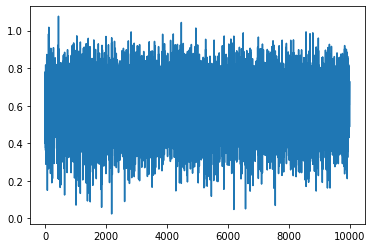

In [23]:
plt.plot(positions[:,0,0])

Comparemos la nueva distribución de densidad de probabilidad extraida de la trayectoria con la referencia teórica del doble pozo asimétrico:

In [24]:
prob_density, coors_x, bins, delta_x = get_probability_density (positions[:,0,0], [-2.0,2.0]*unit.nanometers, 400)

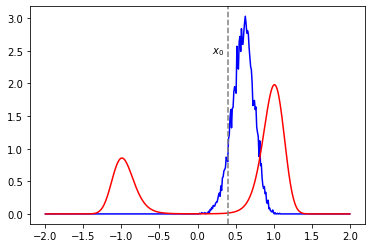

In [28]:
plt.plot(coors_x, prob_density, color='blue')
plt.plot(coors_x, prob_density_teo, color='red')
plt.axvline(x=xo._value,linestyle='--',color='gray')
plt.text(xo._value-0.05, 2.5,'$x_{0}$', horizontalalignment='right', verticalalignment='center')
plt.show()

Y comprobemos por último que la desviación media con respecto a la posición media es aproximada a la del potencial armónico:

In [30]:
print("La desviación media teórica únicamente del potencial armónico es:", pozo_armonico.standard_deviation(T))
print("La desviación media observada del potencial de doble pozo más el armónico es:",positions[:,0,0].std())

La desviación media teórica únicamente del potencial armónico es: 0.14096831607068153 nm
La desviación media observada del potencial de doble pozo más el armónico es: 0.14270306 nm


Parece que nuestro potencial armónico confinante es lo suficientemente fuerte como para prevalecer en su efecto sobre el potencial sustrato original.

Cuando añadimos un termino adicional a un potencial estamos obviamente modificando la termodinámica del sistema con respecto al sistema original, la función de densidad de probabilidad ha quedado alterada. No en vano estamos añadiendo el término adicional para confinar al sistema en una región limitada del espacio. Ahora, ¿podemos decir algo del sistema original mediante la observación del sistema alterado? ¿Podemos repesar la distribución de probabilidad observada del sistema alterado para obtener la distribución original? Veamos paso a paso.

Supongamos, en un caso más general, que al sistema original con energía potencial $U(q)$ añadimos un potencial adicional que depende por ejemplo de la coordenada de reacción $L(q)$, $V(L(q))$. Tenemos entonces que la probabilidad de encontrar al sistema en el valor concreto $l$ de la coordenada de reacción $L(q)$ es:

\begin{equation}
P_{U+V}(l) = \frac{1}{Z_{U+V}} \int_{-\infty}^{\infty} e^{-\frac{U(\vec{q})+V(L(\vec{q}))}{k_{B}T}} \delta (l - L(\vec{q})) d\vec{q}
\end{equation}

donde:

\begin{equation}
Z_{U+V} = \int_{-\infty}^{\infty} e^{-\frac{U(\vec{q})+V(L(\vec{q}))}{k_{B}T}} d\vec{q}
\end{equation}

En primer lugar debemos apuntar que los dos terminos del potencial en la exponencial factorizan. Por ejemplo, podemos reescribir la función de partición total del potencial $U(\vec{q})+V(L(\vec{q}))$ como:

\begin{equation}
Z_{U+V} = \int_{-\infty}^{\infty} e^{-\frac{U(\vec{q})}{k_{B}T}} e^{-\frac{V(L(\vec{q}))}{k_{B}T}} d\vec{q}
\end{equation}


En el caso sencillo de nuestro doble pozo con un potencial armónico podemos ver que:
    
\begin{equation}
P_{U+V}(x) = \frac{1}{Z_{U+V}} e^{-\frac{U(x)+V(x)}{k_{B}T}} = \frac{Z_{U}}{Z_{U+V}} \frac{1}{Z_{U}} e^{-\frac{U(x)}{k_{B}T}} e^{-\frac{V(x)}{k_{B}T}}
\end{equation}

Y como:

\begin{equation}
P_{U}(x) = \frac{1}{Z_{U}} e^{-\frac{U(x)}{k_{B}T}}
\end{equation}

\begin{equation}
P_{U+V}(x) = \frac{Z_{U}}{Z_{U+V}} e^{-\frac{V(x)}{k_{B}T}} P_{U}(x)
\end{equation}

O dicho de otra manera:

\begin{equation}
P_{U}(x) = \frac{Z_{U+V}}{Z_{U}} e^{\frac{V(x)}{k_{B}T}} P_{U+V}(x)
\end{equation}

\begin{equation}
P_{U}(x) \propto e^{\frac{V(x)}{k_{B}T}} P_{U+V}(x)
\end{equation}

Donde la constante de proporcionalidad es eso, una constante que no depende de $x$.

## Umbrellas

In [ ]:
limite_inferior_x = -1.5*unit.nanometers
limite_superior_x = 1.5*unit.nanometers
n_umbrellas = 50

centros = np.zeros([n_umbrellas,3]) * unit.nanometers
centros[:,0] = np.linspace(limite_inferior_x._value, limite_superior_x._value, n_umbrellas, endpoint=True)*unit.nanometers

ks = np.repeat(30.0, n_umbrellas) * unit.kilocalories_per_mole/ unit.nanometers**2

In [ ]:
from copy import deepcopy
import simtk.openmm as mm
from tqdm import tqdm

trayectorias_umbrellas = []

for ii in tqdm(range(n_umbrellas)):
    
    system = deepcopy(double_well_asymmetric.system)
    
    centro = centros[ii]
    k = ks[ii]
    
    force = mm.CustomExternalForce('0.5*k*(x-xo)^2')
    force.addGlobalParameter('k', k)
    force.addGlobalParameter('xo', centro[0])
    for ii in range(double_well_asymmetric.n_particles):
        force.addParticle(ii, [])
    system.addForce(force)
    
    initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
    initial_positions[0,:] = centro
    initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
    
    times, positions, _, _, _ = langevin_NVT (system, temperature = T,
                                              friction = 1.0/unit.picoseconds,
                                              initial_positions = initial_positions,
                                              initial_velocities = initial_velocities,
                                              integration_timestep = 0.1 * unit.picoseconds,
                                              saving_timestep = 2.0 * unit.picoseconds,
                                              total_time = 400.0 * unit.picoseconds,
                                              verbose=False)
    
    trayectorias_umbrellas.append(positions)
    

In [ ]:
for ii in range(n_umbrellas):
    prob_density, coors_x, _, _ = probability_density (trayectorias_umbrellas[ii][:,:,0], [-2.0,2.0]*unit.nanometers, 400)
    plt.plot(coors_x, prob_density)

In [ ]:
k = 30.0 * unit.kilocalories_per_mole/unit.nanometer**2
xo = 0.4 * unit.nanometers

force = mm.CustomExternalForce('0.5*k*(x-xo)^2')
force.addGlobalParameter('k', k)
force.addGlobalParameter('xo', centro[0])
for ii in range(double_well_asymmetric.n_particles):
    force.addParticle(ii, [])
double_well_asymmetric.addForce(force)

In [ ]:
# Condiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

# Simulación
times, positions, _, _, _ = langevin_NVT (double_well_asymmetric.system, temperature = T,
                                          friction = 1.0/unit.picoseconds,
                                          initial_positions = initial_positions,
                                          initial_velocities = initial_velocities,
                                          integration_timestep = 0.2 * unit.picoseconds,
                                          saving_timestep = 10.0 * unit.picoseconds,
                                          total_time = 0.3 * unit.microseconds)

De esta manera, para el sistema $U(x)+V(x)$


Se trata de añadir un bias potential para samplear localmente una región.
Puede ser usado desde en una coordenada de reacción sencillas hasta en un subespacio del espacio de coordenadas mas complejo.
Se combina con Weighted-Histogram-Analysis para el cálculo de paisajes de energías libres o potential mean force

## Notas
- Tiene la ventaja de que podemos ir añadiendo umbrellas sobre el set inicial para refinar el resultado o hacer que converja más rapidamente o mejor
- Se puede combinar con otras técnicas de sampleado, incluso con markov state models

## Ver

https://www.plumed.org/doc-v2.5/user-doc/html/belfast-4.html

